**setup**

In [2]:
import glob
import os

#adjust the paths
files=glob.glob('/reg/d/psdm/amo/amolr9316/scratch/zimmf/rot2/*final*.npz')
outpath='/reg/d/psdm/amo/amolr9316/scratch/zimmf/rot2/plots'

#make sure output path exists
if not os.path.exists(outpath):
    os.makedirs(outpath)

In [ ]:
files

**plot**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.table
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['savefig.dpi']=150 #or 600 if big sample
plt.rcParams['image.interpolation']='nearest'

%matplotlib inline
def rebin(arr, n):
    shape = (
             arr.shape[0]//(2**n), (2**n),
             arr.shape[1]//(2**n), (2**n))
    return arr.reshape(shape).mean(-1).mean(-2)

def addtable(ax,settings):
    keys=['simtype','E','Natoms','a','rndphase','rndpos','ax','ay','az','detz','pixelsize','Nimg','Nphotons','bin']
    units={
        'simtype': '',
        'E': 'eV',
        'Natoms': 'atoms',
        'a': 'Angstrom',
        'rndphase': '',
        'rndpos': '',
        'detz': 'cm',
        'pixelsize': 'um',
        'Nimg': 'images',
        'Nphotons': 'photons/image',
        'bin': 'times in each direction',
        'r': 'nm',
        'ax': 'degree rotation',
        'ay': 'degree rotation',
        'az': 'degree rotation'
    }
    cells=[]
    rows=[]
    columns=['Value','Unit']
    for k in keys:
        try:
            cells.append([str(settings[k]),units[k]])
        except KeyError:
            continue
        rows.append(k)
    ax.table(cellText=cells,rowLabels=rows,colLabels=columns,loc='center',colWidths=[0.2,0.4],fontsize=20)
    ax.axis('tight')
    ax.axis('off')

def cutnan(array):
    ind0=~np.all(np.isnan(array),axis=0)
    ind1=~np.all(np.isnan(array),axis=1)
    return array[ind1,:][:,ind0]

def rebin(arr,n):
    shape = ( arr.shape[0]//2**n, 2**n,
              arr.shape[1]//2**n, 2**n,
             arr.shape[2]//2**n, 2**n)
    return arr.reshape(shape).mean(-1).mean(1).mean(-2)

for finalfile in files: 
    print('processing %s'%finalfile)
    suffix=os.path.split(finalfile)[-1][:-10]
    
    out=np.load(finalfile)['out']
    settings=np.load(finalfile)['settings'].take(0)
    Nimg=settings['Nimg']
    Natoms=settings['Natoms']
    Nphotons=settings['Nphotons']
    bin=settings['bin']

    resxy=out[...,0]
    resxy=np.concatenate((np.flipud(resxy)[:-1,:],resxy),axis=0)
    resxy=np.concatenate((np.fliplr(resxy)[:,:-1],resxy),axis=1)
    resyz=out[0,...]
    resyz=np.concatenate((np.flipud(resyz)[:-1,:],resyz),axis=0)
    resyz=np.concatenate((np.fliplr(resyz)[:,:-1],resyz),axis=1)

    out2=rebin(out,max(1,2-bin))
    out2=np.concatenate((np.flip(out2,axis=2),out2[:,:,:-1]),axis=2)
    out2=np.concatenate((np.flip(out2,axis=0),out2[:-1,:,:]),axis=0)
    out2=np.concatenate((np.flip(out2,axis=1),out2[:,:-1,:]),axis=1)


    f=plt.figure()
    f.set_size_inches(21,30)
    f.suptitle('%i atoms, %d photons/image, %i images, bin %i'%(Natoms,Nphotons,Nimg,bin),fontsize=20)           

    ax0=plt.subplot2grid((4,2), (0,0), rowspan=2, projection='3d')
    #f.add_subplot(ax0)
    v3d=np.nanpercentile(out2,99.7)
    xs,ys,zs=np.where(out2>v3d)
    x,y,z=((xs,ys,zs)-np.array(np.array(out2.shape)/2)[np.newaxis].T)*2
    v=out2[xs,ys,zs]
    ax0.scatter(x,y,z,c=v,alpha=0.1)
    ax0.axis('square')
    ax0.set_xlim3d(-out2.shape[0]/2,out2.shape[0]/2)
    ax0.set_ylim3d(-out2.shape[1]/2,out2.shape[1]/2)
    ax0.set_zlim3d(-out2.shape[2]/2,out2.shape[2]/2)
    ax0.set_title('3d')

    vmax=np.nanpercentile(resyz,99.95)
    vmin=1.0
    ax1=plt.subplot2grid((4,2), (0,1), rowspan=2)
    #f.add_subplot(ax1)
    pxy=ax1.matshow(cutnan(resxy),vmin=vmin,vmax=vmax,cmap=plt.cm.magma)
    ax1.axis('off')
    ax1.set_title('qz=0')
    #plt.colorbar(pxy,ax=ax1)

    ax2=plt.subplot2grid((4,2), (2,0), colspan=2)
    f.add_subplot(ax2)
    pyz=ax2.matshow(cutnan(np.rot90(resyz)),vmin=vmin,vmax=vmax,cmap=plt.cm.magma)
    ax2.axis('off')
    ax2.set_title('qx=0')
    plt.colorbar(pyz,ax=ax2)

    ax3=plt.subplot2grid((4,2), (3,0))
    #f.add_subplot(ax3)
    addtable(ax3,settings)

    ax4=plt.subplot2grid((4,2), (3,1),projection='3d')
    out3=rebin(out,max(1,2-bin))
    zs=np.argmax(np.isnan(out3),axis=2)
    xs,ys=np.meshgrid(*[np.arange(0, x) for x in zs.shape])
    ax4.plot_wireframe(xs, ys, zs,rstride=5,cstride=5,color='r',alpha=0.3)
    xs,ys,zs=np.where(out3>v3d)
    ax4.scatter(xs,ys,zs)
    ax4.view_init(30, 170)
    ax4.set_title('reconstruction limit (red)')

    outfile='%s/reconstruction-%s.png'%(outpath,suffix)
    f.savefig(outfile)
    plt.close()
    print('saved as %s'%outfile)

    snr=(np.nanmax(resxy[resxy.shape[0]//2,...])-np.nanmedian(resxy))/np.nanstd(resxy)
    print('SNR estimate: %f'%snr)

    f,ax1,=plt.subplots(1,1)
    f.set_size_inches(6,3)
    f.suptitle('%i atoms, %d photons/image, %i images, bin %i'%(Natoms,Nphotons,Nimg,bin),fontsize=20)           
    f.subplots_adjust(top=0.85)
    ax1.plot(resxy[resxy.shape[0]//2,...])
    ax1.set_title('SNR: %f'%snr)
    outfile='%s/profile-%s.png'%(outpath,suffix)
    f.savefig(outfile)
    print('saved as %s'%outfile)
    plt.close()

In [5]:
finalfile='/reg/d/psdm/amo/amolr9316/scratch/zimmf/rot2/gridfcc_rotz10-10000-final.npz'

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.table
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['savefig.dpi']=150 #or 600 if big sample
plt.rcParams['image.interpolation']='nearest'

%matplotlib inline
def rebin(arr, n):
    shape = (
             arr.shape[0]//(2**n), (2**n),
             arr.shape[1]//(2**n), (2**n))
    return arr.reshape(shape).mean(-1).mean(-2)

def addtable(ax,settings):
    keys=['simtype','E','Natoms','a','rndphase','rndpos','ax','ay','az','detz','pixelsize','Nimg','Nphotons','bin']
    units={
        'simtype': '',
        'E': 'eV',
        'Natoms': 'atoms',
        'a': 'Angstrom',
        'rndphase': '',
        'rndpos': '',
        'detz': 'cm',
        'pixelsize': 'um',
        'Nimg': 'images',
        'Nphotons': 'photons/image',
        'bin': 'times in each direction',
        'r': 'nm',
        'ax': 'degree rotation',
        'ay': 'degree rotation',
        'az': 'degree rotation'
    }
    cells=[]
    rows=[]
    columns=['Value','Unit']
    for k in keys:
        try:
            cells.append([str(settings[k]),units[k]])
        except KeyError:
            continue
        rows.append(k)
    ax.table(cellText=cells,rowLabels=rows,colLabels=columns,loc='center',colWidths=[0.2,0.4],fontsize=20)
    ax.axis('tight')
    ax.axis('off')

def cutnan(array):
    ind0=~np.all(np.isnan(array),axis=0)
    ind1=~np.all(np.isnan(array),axis=1)
    return array[ind1,:][:,ind0]

def rebin(arr,n):
    shape = ( arr.shape[0]//2**n, 2**n,
              arr.shape[1]//2**n, 2**n,
             arr.shape[2]//2**n, 2**n)
    return arr.reshape(shape).mean(-1).mean(1).mean(-2)


print('processing %s'%finalfile)
suffix=os.path.split(finalfile)[-1][:-10]

out=np.load(finalfile)['out']
settings=np.load(finalfile)['settings'].take(0)
Nimg=settings['Nimg']
Natoms=settings['Natoms']
Nphotons=settings['Nphotons']
bin=settings['bin']

resxy=out[...,0]
resxy=np.concatenate((np.flipud(resxy)[:-1,:],resxy),axis=0)
resxy=np.concatenate((np.fliplr(resxy)[:,:-1],resxy),axis=1)
resyz=out[0,...]
resyz=np.concatenate((np.flipud(resyz)[:-1,:],resyz),axis=0)
resyz=np.concatenate((np.fliplr(resyz)[:,:-1],resyz),axis=1)

out2=rebin(out,max(1,2-bin))
out2=np.concatenate((np.flip(out2,axis=2),out2[:,:,:-1]),axis=2)
out2=np.concatenate((np.flip(out2,axis=0),out2[:-1,:,:]),axis=0)
out2=np.concatenate((np.flip(out2,axis=1),out2[:,:-1,:]),axis=1)



processing /reg/d/psdm/amo/amolr9316/scratch/zimmf/rot2/gridfcc_rotz10-10000-final.npz


In [ ]:
out2=out[::2,::2,::2]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
zs=np.argmax(np.isnan(out2),axis=2)
xs,ys=np.meshgrid(*[np.arange(0, x) for x in zs.shape])
ax.plot_wireframe(xs, ys, zs,rstride=5,cstride=5,color='r',alpha=0.3)

from skimage import morphology
b=morphology.ball(8)
out2[morphology.binary_dilation(np.isnan(out2),b)]=0
xs,ys,zs=np.where(np.logical_and(out2>1.3,morphology.dilation(out2,selem=b)==out2))


#xs,ys,zs=np.where(out2>1.3)
ax.scatter(xs,ys,zs)
ax.view_init(30, 170)

/reg/d/psdm/amo/amolr9316/scratch/zimmf/rot/gridfcc_roty10-100000-final.npz


/reg/neh/home5/zimmf/.conda/envs/local2/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater
/reg/neh/home5/zimmf/.conda/envs/local2/lib/python2.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


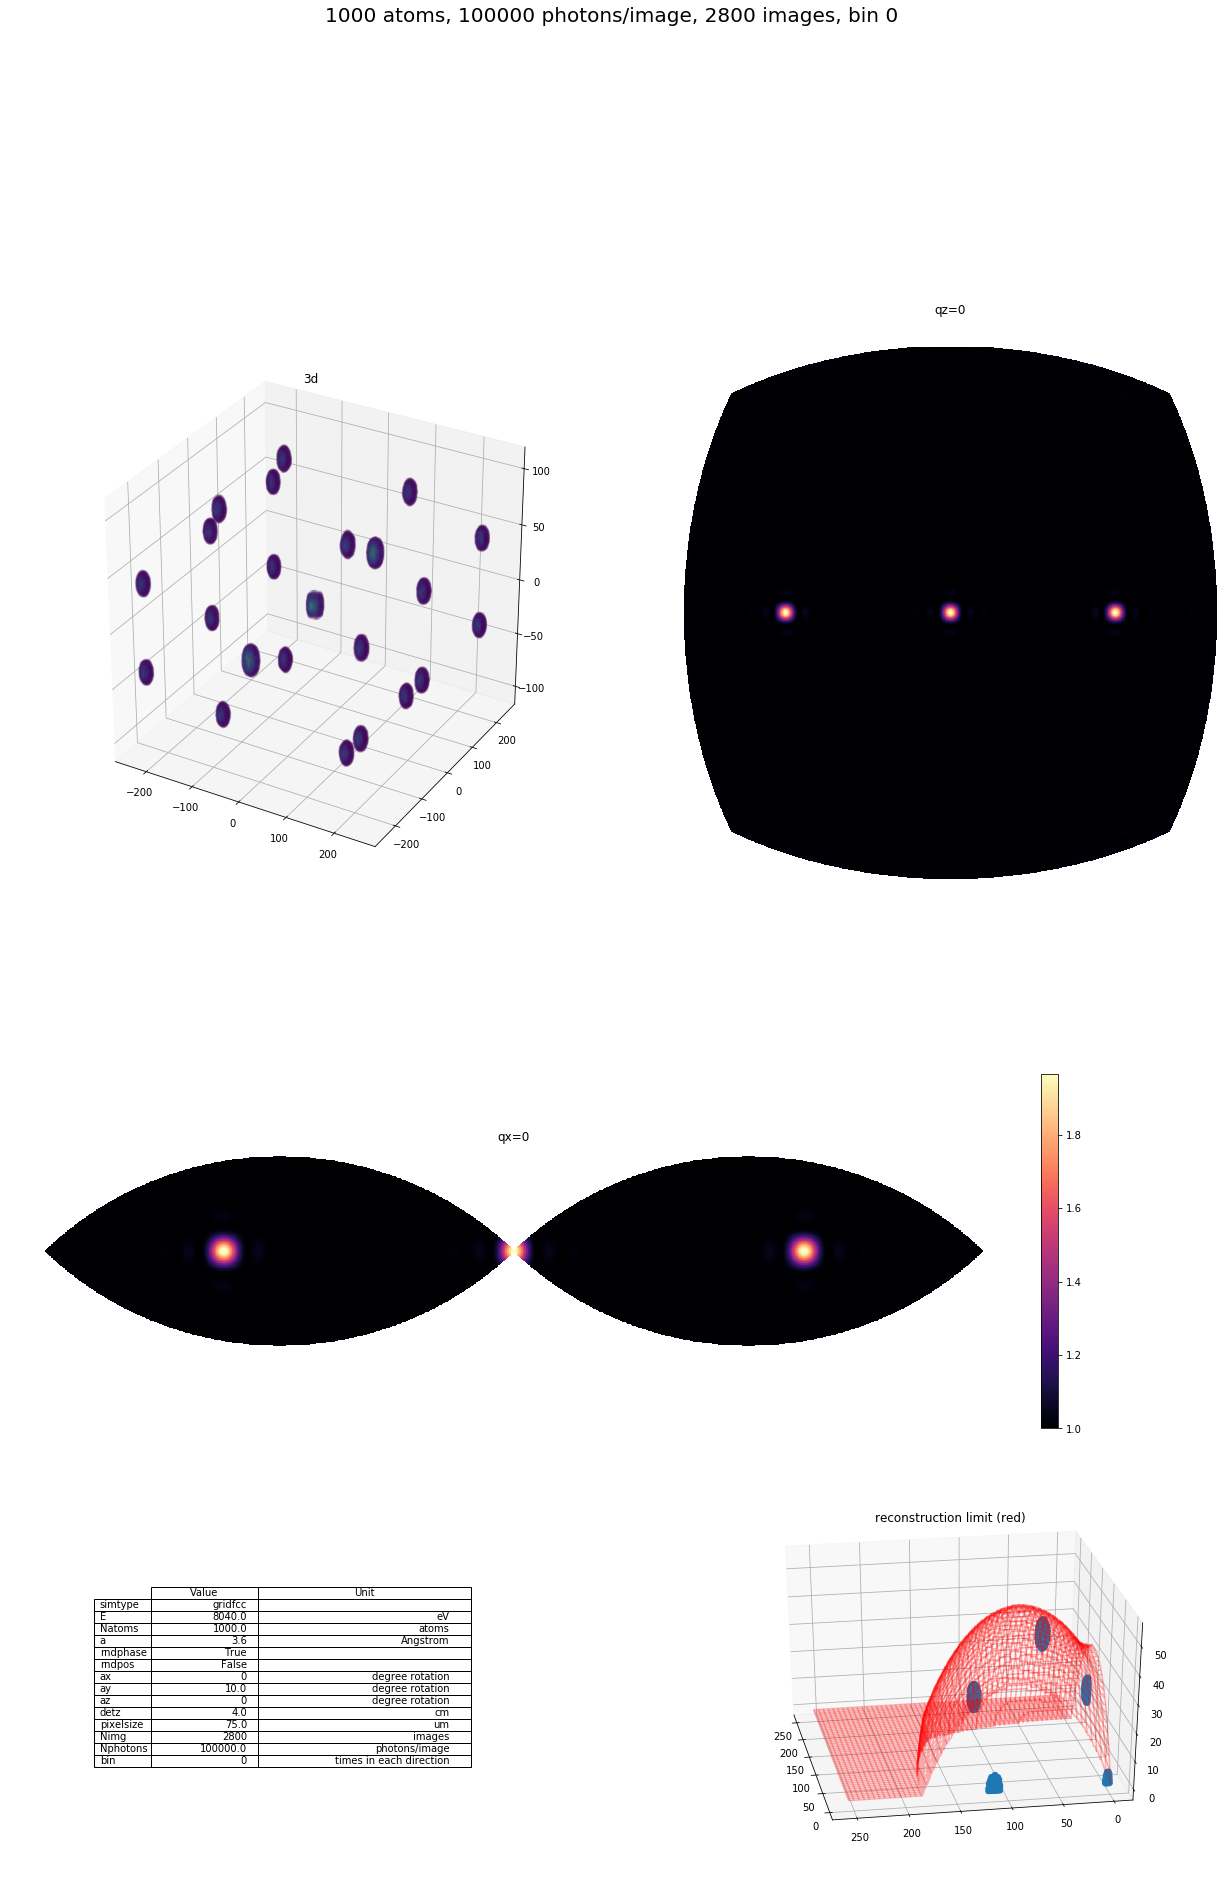

In [197]:
def cutnan(array):
    ind0=~np.all(np.isnan(array),axis=0)
    ind1=~np.all(np.isnan(array),axis=1)
    return array[ind1,:][:,ind0]
def rebin(arr,n):
    shape = ( arr.shape[0]//2**n, 2**n,
              arr.shape[1]//2**n, 2**n,
             arr.shape[2]//2**n, 2**n)
    return arr.reshape(shape).mean(-1).mean(1).mean(-2)

finalfile=files[-2]
print(finalfile)
out=np.load(finalfile)['out']
settings=np.load(finalfile)['settings'].take(0)
Nimg=settings['Nimg']
Natoms=settings['Natoms']
Nphotons=settings['Nphotons']
bin=settings['bin']

resxy=out[...,0]
resxy=np.concatenate((np.flipud(resxy)[:-1,:],resxy),axis=0)
resxy=np.concatenate((np.fliplr(resxy)[:,:-1],resxy),axis=1)
resyz=out[0,...]
resyz=np.concatenate((np.flipud(resyz)[:-1,:],resyz),axis=0)
resyz=np.concatenate((np.fliplr(resyz)[:,:-1],resyz),axis=1)

out2=rebin(out,2)
out2=np.concatenate((np.flip(out2,axis=2),out2[:,:,:-1]),axis=2)
out2=np.concatenate((np.flip(out2,axis=0),out2[:-1,:,:]),axis=0)
out2=np.concatenate((np.flip(out2,axis=1),out2[:,:-1,:]),axis=1)


f=plt.figure()
f.set_size_inches(21,30)
f.suptitle('%i atoms, %d photons/image, %i images, bin %i'%(Natoms,Nphotons,Nimg,bin),fontsize=20)           

ax0=plt.subplot2grid((4,2), (0,0), rowspan=2, projection='3d')
#f.add_subplot(ax0)
v3d=np.nanpercentile(out2,99.8)
xs,ys,zs=np.where(out2>v3d)
x,y,z=((xs,ys,zs)-np.array(np.array(out2.shape)/2)[np.newaxis].T)*2
v=out2[xs,ys,zs]
ax0.scatter(x,y,z,c=v,alpha=0.1)
ax0.set_xlim3d(-out2.shape[0]/2,out2.shape[0]/2)
ax0.set_ylim3d(-out2.shape[1]/2,out2.shape[1]/2)
ax0.set_zlim3d(-out2.shape[2]/2,out2.shape[2]/2)
ax0.axis('square')
ax0.set_title('3d')

vmax=np.nanpercentile(resyz,99.95)
vmin=1.0
ax1=plt.subplot2grid((4,2), (0,1), rowspan=2)
#f.add_subplot(ax1)
pxy=ax1.matshow(cutnan(resxy),vmin=vmin,vmax=vmax,cmap=plt.cm.magma)
ax1.axis('off')
ax1.set_title('qz=0')
#plt.colorbar(pxy,ax=ax1)

ax2=plt.subplot2grid((4,2), (2,0), colspan=2)
f.add_subplot(ax2)
pyz=ax2.matshow(cutnan(np.rot90(resyz)),vmin=vmin,vmax=vmax,cmap=plt.cm.magma)
ax2.axis('off')
ax2.set_title('qx=0')
plt.colorbar(pyz,ax=ax2)

ax3=plt.subplot2grid((4,2), (3,0))
#f.add_subplot(ax3)
addtable(ax3,settings)

ax4=plt.subplot2grid((4,2), (3,1),projection='3d')
out3=rebin(out,2)
zs=np.argmax(np.isnan(out3),axis=2)
xs,ys=np.meshgrid(*[np.arange(0, x) for x in zs.shape])
ax4.plot_wireframe(xs, ys, zs,rstride=5,cstride=5,color='r',alpha=0.3)
xs,ys,zs=np.where(out3>v3d)
ax4.scatter(xs,ys,zs)
ax4.view_init(30, 170)
ax4.set_title('reconstruction limit (red)')

plt.show()

In [147]:
def cutnan(array):
    ind0=~np.all(np.isnan(array),axis=0)
    ind1=~np.all(np.isnan(array),axis=1)
    return array[ind1,:][:,ind0].T

def rebin(arr,n):
    shape = ( arr.shape[0]//2**n, 2**n,
              arr.shape[1]//2**n, 2**n,
             arr.shape[2]//2**n, 2**n)
    return arr.reshape(shape).mean(-1).mean(1).mean(-2)